## Process image
Input: image folder collected by Xiaohu.
Output: image numpy arrays and an index dictionary.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import psutil

In [2]:
with open('../statesToData.pickle', 'rb') as handle:
    statesToData = pickle.load(handle)

In [3]:
print(statesToData["CA"].CENSUS_ID) # 11 digits.
print(statesToData.keys())

40        06111000902
41        06111000902
42        06111000902
43        06111000902
44        06111000902
             ...     
781780    06057000701
781781    06057000701
781782    06057000701
781811    06053011900
781812    06053011900
Name: CENSUS_ID, Length: 155989, dtype: object
dict_keys(['NC', 'WI', 'NY', 'MD', 'PA', 'CA', 'TX', 'AZ', 'WA', 'IL', 'KY', 'MT', 'IA', 'GA', 'ME', 'VA', 'SC', 'WV', 'FL', 'NH', 'MN', 'NE', 'AR', 'NJ', 'SD', 'NM', 'OK', 'MI', 'VT', 'ID', 'DE', 'MA', 'WY', 'CO', 'IN', 'AL', 'TN', 'HI', 'AK', 'OH', 'RI', 'LA', 'OR', 'KS', 'UT', 'MO', 'DC', 'NV', 'ND', 'MS', 'CT'])


In [4]:
# file names in the folder
standard_file_name_list = ['road_0.tif', 'road_1.tif', 'building_0.tif', 'building_1.tif']
num_channels = len(standard_file_name_list)

In [5]:
# check directory names from Xiaohu's collection
def digit_counts(list_, SAT = False):
    # output the number of items with 10 and 11 digits. 
    # give warning if the items have number of digits different from 10 and 11.
    d_10 = 0
    d_11 = 0

    if SAT:
        for idx in np.arange(len(list_)):
            if len(list_[idx]) == 17: # 10+3+4 because 3 represents "wms" and 4 represents ".jpg" ...
                d_10 += 1
            elif len(list_[idx]) == 18: # 11+3+4 because 3 represents "wms" and 4 represents ".jpg" ...
                d_11 += 1
        if d_10 + d_11 < len(list_):
            print("Warning: Total sum does not add up...")
    else:
        for idx in np.arange(len(list_)):
            if len(list_[idx]) == 10:
                d_10 += 1
            elif len(list_[idx]) == 11:
                d_11 += 1
        if d_10 + d_11 < len(list_):
            print("Warning: Total sum does not add up...")
            
    return d_10, d_11

# Xiaohu's directory names for osm and sat
osm_dir = '/mnt/shenhao/sat_image_nhts/code/data_initial/osm/img'
satellite_dir = '/mnt/shenhao/sat_image_nhts/code/data_initial/satellite/img'
# 
osm_directory_list = os.listdir(osm_dir)
sat_directory_list = os.listdir(satellite_dir)

print(osm_directory_list[:10])
print(sat_directory_list[:10])

['36055014905', '45035010604', '50001960900', '4013071801', '18097321200', '48113007914', '40145030512', '24005411201', '6085511914', '45045002805']
['wms37119006006.jpg', 'wms21111009300.jpg', 'wms36071000300.jpg', 'wms48113017900.jpg', 'wms22109000202.jpg', 'wms37047930600.jpg', 'wms51700032131.jpg', 'wms48201534100.jpg', 'wms6073000600.jpg', 'wms22071012800.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
road0


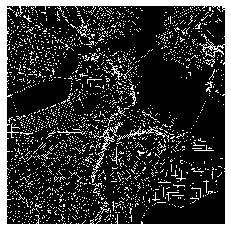

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


road1


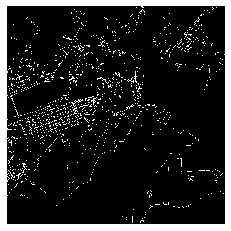

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


build0


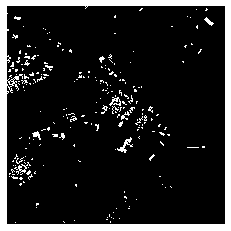

build1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


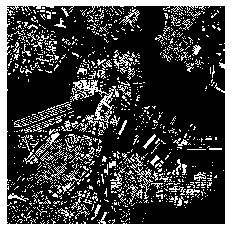

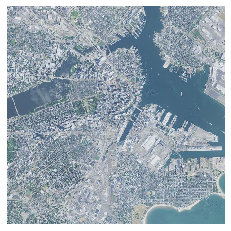

(900, 900)
(900, 900)
(900, 900)
(900, 900)
(900, 900, 3)
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [5672.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 5672. 5672.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 2140. 5672. 6640.    0.    0.    0.    0.]]
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 761.   0.   0.   0.   0.   0.   0.   0.   0.]
 [761. 761.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.

In [6]:
# visualize images to get intuition.
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

# Resources about Census Tract IDs
# https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf
# Need to use QGIS to obtain the relationship between addresses and census tract IDs.

# Play with examples: Boston, NYC, etc.
print('25025070101' in osm_directory_list)
    
# visualize the images of a census_id    
census_idx = '25025070101' # Boston
# census_idx = '36061016500' # NYC is in the data set.

road_0_ex = osm_dir+'/'+census_idx+'/road_0.tif'
road_1_ex = osm_dir+'/'+census_idx+'/road_1.tif'
building_0_ex = osm_dir+'/'+census_idx+'/building_0.tif'
building_1_ex = osm_dir+'/'+census_idx+'/building_1.tif'
wms_ex = satellite_dir+'/'+'wms'+census_idx+'.jpg'

road_0_img = cv2.imread(road_0_ex, cv2.IMREAD_UNCHANGED)
print("road0")
imshow(road_0_img)
road_1_img = cv2.imread(road_1_ex, cv2.IMREAD_UNCHANGED)
print("road1")
imshow(road_1_img)
building_0_img = cv2.imread(building_0_ex, cv2.IMREAD_UNCHANGED)
print("build0")
imshow(building_0_img)
building_1_img = cv2.imread(building_1_ex, cv2.IMREAD_UNCHANGED)
print("build1")
imshow(building_1_img)
wms_img = cv2.imread(wms_ex, cv2.IMREAD_UNCHANGED)
imshow(wms_img)

# shape
print(road_0_img.shape)
print(road_1_img.shape)
print(building_0_img.shape)
print(building_1_img.shape)
print(wms_img.shape)

# values
print(road_0_img[:10,:10]) # float: larger than 255
print(building_0_img[:10,:10]) # float: larger than 255
print(wms_img[:10,:10,:]) # int: 0-255

[[   0.    0. 1995.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  372.    0. 1993. 1993.    0.    0.    0.    0.    0.]
 [   0.  372.    0.    0.    0. 1993.    0.    0.    0.    0.]
 [ 372.    0.    0.    0.    0.    0. 1993. 1993.    0.    0.]
 [ 372.    0.    0.    0.    0.    0.    0.    0. 1993.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0. 1993.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.  376.]]
(900, 900)
road0


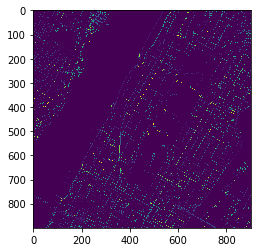

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[   0.    0.    0.]
  [   0.    0.    0.]
  [1995. 1995. 1995.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [ 372.  372.  372.]
  [   0.    0.    0.]
  [1993. 1993. 1993.]
  [1993. 1993. 1993.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [ 372.  372.  372.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [1993. 1993. 1993.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[ 372.  372.  372.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [1993. 1993. 1993.]
  [1993. 1993. 1993.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[ 372.  372.  372.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]
  

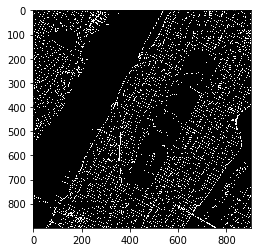

[[[152 151 131]
  [137 136 116]
  [168 167 147]
  [176 175 155]
  [154 153 133]
  [147 146 126]
  [158 154 135]
  [174 170 151]
  [153 149 130]
  [ 92  88  69]]

 [[108 107  87]
  [190 189 169]
  [126 125 105]
  [148 147 127]
  [149 148 128]
  [178 177 157]
  [125 121 102]
  [171 167 148]
  [190 186 167]
  [124 120 101]]

 [[123 122 102]
  [195 194 174]
  [116 115  95]
  [181 180 160]
  [142 138 119]
  [174 170 151]
  [149 145 126]
  [165 161 142]
  [198 192 173]
  [158 152 133]]

 [[135 134 114]
  [161 160 140]
  [ 93  92  72]
  [166 165 145]
  [189 185 166]
  [193 189 170]
  [184 180 161]
  [131 127 108]
  [127 121 102]
  [177 171 152]]

 [[162 161 141]
  [122 121 101]
  [135 131 112]
  [202 198 179]
  [178 174 155]
  [183 179 160]
  [245 239 220]
  [134 128 109]
  [148 142 123]
  [129 123 104]]

 [[142 141 121]
  [113 112  92]
  [ 96  92  73]
  [148 144 125]
  [178 174 155]
  [161 157 138]
  [199 193 174]
  [241 235 216]
  [147 141 122]
  [175 169 150]]

 [[174 171 150]
  [ 92  89  

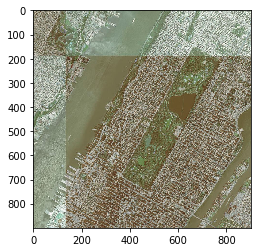

[[[131 151 152]
  [116 136 137]
  [147 167 168]
  [155 175 176]
  [133 153 154]
  [126 146 147]
  [135 154 158]
  [151 170 174]
  [130 149 153]
  [ 69  88  92]]

 [[ 87 107 108]
  [169 189 190]
  [105 125 126]
  [127 147 148]
  [128 148 149]
  [157 177 178]
  [102 121 125]
  [148 167 171]
  [167 186 190]
  [101 120 124]]

 [[102 122 123]
  [174 194 195]
  [ 95 115 116]
  [160 180 181]
  [119 138 142]
  [151 170 174]
  [126 145 149]
  [142 161 165]
  [173 192 198]
  [133 152 158]]

 [[114 134 135]
  [140 160 161]
  [ 72  92  93]
  [145 165 166]
  [166 185 189]
  [170 189 193]
  [161 180 184]
  [108 127 131]
  [102 121 127]
  [152 171 177]]

 [[141 161 162]
  [101 121 122]
  [112 131 135]
  [179 198 202]
  [155 174 178]
  [160 179 183]
  [220 239 245]
  [109 128 134]
  [123 142 148]
  [104 123 129]]

 [[121 141 142]
  [ 92 112 113]
  [ 73  92  96]
  [125 144 148]
  [155 174 178]
  [138 157 161]
  [174 193 199]
  [216 235 241]
  [122 141 147]
  [150 169 175]]

 [[150 171 174]
  [ 68  89  

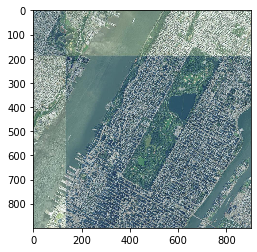

In [7]:
# test the visualization tools in CV2 and plt.
#census_idx = '25025070101' # Boston
census_idx = '36061016500' # NYC is in the data set.

road_0_ex = osm_dir+'/'+census_idx+'/road_0.tif'
road_1_ex = osm_dir+'/'+census_idx+'/road_1.tif'
building_0_ex = osm_dir+'/'+census_idx+'/building_0.tif'
building_1_ex = osm_dir+'/'+census_idx+'/building_1.tif'
wms_ex = satellite_dir+'/'+'wms'+census_idx+'.jpg'

road_0_img = cv2.imread(road_0_ex, cv2.IMREAD_UNCHANGED)
wms_img = cv2.imread(wms_ex, cv2.IMREAD_UNCHANGED)

# test osm images
print(road_0_img[:10, :10])
print(road_0_img.shape)
print("road0")
plt.imshow(road_0_img)
plt.show()

image = cv2.cvtColor(road_0_img, cv2.COLOR_GRAY2RGB)
print(image[:10,:10])
print(image.shape)
print("image")
plt.imshow(image)
plt.show()

# test sat images
print(wms_img[:10, :10, :])
print(wms_img.shape)
print("wmsimg")
plt.imshow(wms_img)
plt.show()

image = cv2.cvtColor(wms_img, cv2.COLOR_BGR2RGB)
print(image[:10,:10])
print(image.shape)
plt.imshow(image)
plt.show()

In [8]:
census_idx = '25025070101' # Boston
print(statesToData["MA"].loc[statesToData["MA"]["CENSUS_ID"] == census_idx, ["HHVEHCNT","TRPTRANS","TRIPPURP"]])
# print(statesToData["MA"]["CENSUS_ID"][statesToData["MA"]["CENSUS_ID"] == census_idx, :])

        HHVEHCNT  TRPTRANS TRIPPURP
200824         0         1        3
200825         0         6        4
200826         0         6        4
200827         0         6        4


In [9]:
print("------")
d_10, d_11 = digit_counts(osm_directory_list)
print("10 digits: ", d_10, "; 11 digits: ", d_11, "Total 10 and 11 digts: ", d_10+d_11)
print("Total items in OSM: ", len(osm_directory_list))

print("------")
d_10, d_11 = digit_counts(sat_directory_list, SAT = True)
print("10 digits: ", d_10, "; 11 digits: ", d_11, "Total 10 and 11 digts: ", d_10+d_11)
print("Total items in SAT: ", len(sat_directory_list))

# Q: There is one unit difference...What is it?

------
10 digits:  7989 ; 11 digits:  27234 Total 10 and 11 digts:  35223
Total items in OSM:  35223
------
10 digits:  7989 ; 11 digits:  27234 Total 10 and 11 digts:  35223
Total items in SAT:  35224


In [10]:
# Count the census IDs in the NHTS data set.
folder_new_id_set = set()
for key in statesToData:
    for census_id in statesToData[key].CENSUS_ID:
        folder_new_id_set.add(census_id)
print("Total census IDs in NHTS: ", len(folder_new_id_set))

Total census IDs in NHTS:  32681


In [11]:
# The image folder names mismatch the official census IDs. 
# Hence we create a list for the image folder's names. 
folder_old_id_list = []
folder_new_id_list = []
sat_file_old_id_list = []
sat_file_new_id_list = []

for id_ in folder_new_id_set:
    if id_[0] == '0':
        folder_old_id_list.append(id_[1:])
        folder_new_id_list.append(id_)
        sat_file_old_id_list.append('wms'+id_[1:]+'.jpg')
        sat_file_new_id_list.append('wms'+id_+'.jpg')        
    else:
        folder_old_id_list.append(id_) # match up to the folder names...
        folder_new_id_list.append(id_)
        sat_file_old_id_list.append('wms'+id_+'.jpg')
        sat_file_new_id_list.append('wms'+id_+'.jpg')        
        
# print check
d_10,d_11 = digit_counts(folder_old_id_list)
print("Old osm folder id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(folder_new_id_list)
print("New osm folder id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(sat_file_old_id_list, SAT = True)
print("Old sat image files id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)
d_10,d_11 = digit_counts(sat_file_new_id_list, SAT = True)
print("New sat image files id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)


Old osm folder id list:  10 digits:  7487 ; 11 digits:  25194
New osm folder id list:  10 digits:  0 ; 11 digits:  32681
Old sat image files id list:  10 digits:  7487 ; 11 digits:  25194
New sat image files id list:  10 digits:  0 ; 11 digits:  32681


In [12]:
# initialize the image array
file_size = (224, 224) # Use a smaller size of images with 224*224
image_array = np.zeros((len(folder_old_id_list), 3, file_size[0], file_size[1])) # default: black images
print("Image size is: ", sys.getsizeof(image_array)/1000000000, "GB") 
# Note here the size cannot exceed 16*8 = 128G in RAM. The maximum size here is (249 * 249)

Image size is:  39.355244688 GB


In [13]:
# check the system
psutil.cpu_percent()
psutil.virtual_memory()

svmem(total=134747709440, available=79263694848, percent=41.2, used=54199083008, free=930611200, active=58075226112, inactive=72676544512, buffers=1714102272, cached=77903912960, shared=663552, slab=2415099904)

In [14]:
census_id_to_index = {}
empty_images_folder_names = []

In [15]:
# Reading images; need 20 min
import os
empty = 0
colored = 0
not_empty = 0

for folder_name_idx in np.arange(len(folder_old_id_list)):
    # create the index dictionary for the folders.
    census_id_to_index[str(folder_new_id_list[folder_name_idx])] = folder_name_idx
    
    if folder_name_idx%100==0:
        print(folder_name_idx)

    # Fill in the OSM images
    for file_name_idx in np.arange(len(standard_file_name_list)):
        full_file_name = os.path.join("/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/", folder_old_id_list[folder_name_idx], standard_file_name_list[file_name_idx])
        img = cv2.imread(full_file_name, cv2.IMREAD_UNCHANGED)
        if img is None:
            #print("empty")
            #print(standard_file_name_list[file_name_idx])
            empty += 1
            empty_images_folder_names.append(full_file_name)
            pass # default is black images...so when images do not exist. Keep the zeros
        else:
            #print("not empty")
            not_empty += 1
            
            #Dont want bw images
            #image_array[folder_name_idx, file_name_idx, :, :] = cv2.resize(img, file_size).astype(np.uint8)

    # Fill in the Satellite images
    sat_file_name = os.path.join("/mnt/shenhao/sat_image_nhts/code/data_initial/satellite/img/", sat_file_old_id_list[folder_name_idx])
    img = cv2.imread(sat_file_name, cv2.IMREAD_UNCHANGED)
    if img is None:
        #print("empty")
        #print(standard_file_name_list[file_name_idx])
        empty += 1
        empty_images_folder_names.append(sat_file_name)
        pass # default is black images...so when images do not exist. Keep the zeros
    else:
        #print("colored")
        colored += 1
        
        
        #commented out because we only want black and white images in this notebook
        
        # idx: 4
        image_array[folder_name_idx, 0, :, :] = cv2.resize(img[:,:,0], file_size).astype(np.uint8)
        # idx: 5
        image_array[folder_name_idx, 1, :, :] = cv2.resize(img[:,:,1], file_size).astype(np.uint8)
        # idx: 6
        image_array[folder_name_idx, 2, :, :] = cv2.resize(img[:,:,2], file_size).astype(np.uint8)
        


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [16]:
print("empty: ",empty)
print("colored: ",colored) # note satellite images have no missingness.
print("not empty: ", not_empty)
print(len(empty_images_folder_names))

empty:  130724
colored:  32681
not empty:  0
130724


['/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/road_0.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/road_1.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/building_0.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/building_1.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/road_0.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/road_1.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/building_0.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/building_1.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/12009063105/road_0.tif', '/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/12009063105/road_1.tif']


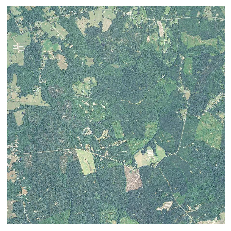

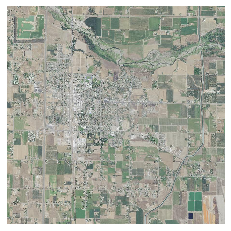

In [18]:
# check emptyness
print(empty_images_folder_names[:10])

empty_index_ex1 = "45057010100" # 11 digits; it misses road_1, building_0, building_1.
empty_index_ex2 = "6021010100" # 10 digits; it misses road_1. Full ID: 06021010100

# example 1
# FIPS 45057: Lancaster County, SC 
wms_ex1 = satellite_dir+'/'+'wms'+empty_index_ex1+'.jpg'
wms_img = cv2.imread(wms_ex1, cv2.IMREAD_UNCHANGED)
imshow(wms_img)

# example 2
# FIPS 06021: Glenn County, CA
wms_ex1 = satellite_dir+'/'+'wms'+empty_index_ex2+'.jpg'
wms_img = cv2.imread(wms_ex1, cv2.IMREAD_UNCHANGED)
imshow(wms_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


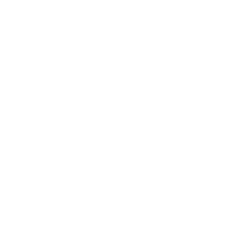

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


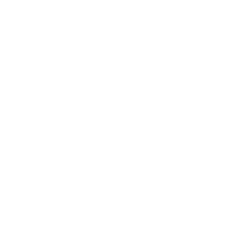

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


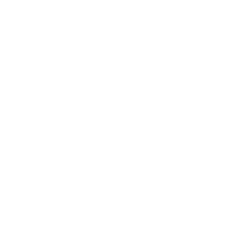

Here


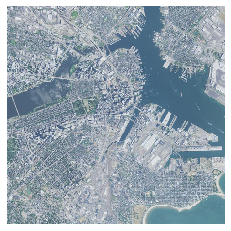

In [19]:
# Double check the processed data. 
census_idx = '25025070101' # Boston
image_idx = census_id_to_index[census_idx]

# note opencv only works with float32 type, and the image_array format (float64) does not work.
road_0_img = image_array[image_idx, 0, :, :].astype('float32') 
imshow(road_0_img)
road_1_img = image_array[image_idx, 1, :, :].astype('float32') 
imshow(road_1_img)
building_0_img = image_array[image_idx, 2, :, :].astype('float32') 
imshow(building_0_img)
# building_1_img = image_array[image_idx, 3, :, :].astype('float32') 
# imshow(building_1_img)

# note opencv only works with uint8 type with RGB channels, and the image_array format (float64) does not work.
print("Here")
wms_img_ = image_array[image_idx, 0:3, :, :].astype('uint8')
# fotmat editting: from channel-first ot channel-last image
wms_img = np.moveaxis(wms_img_, 0, 2)
imshow(wms_img)

In [20]:
# check census_id_to_index
census_id_keys = list(census_id_to_index.keys())
d_10,d_11 = digit_counts(census_id_keys)
print("Final id list: ", "10 digits: ", d_10, "; 11 digits: ", d_11)

Final id list:  10 digits:  0 ; 11 digits:  32681


In [21]:
len(empty_images_folder_names)

130724

In [22]:
for i,elt in enumerate(empty_images_folder_names):
    print(elt)
    if i == 100:
        break

/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/road_0.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/road_1.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/building_0.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/1003010703/building_1.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/road_0.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/road_1.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/building_0.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/18127050103/building_1.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/12009063105/road_0.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/12009063105/road_1.tif
/mnt/Documents/shenhao/sat_image_nhts/code/data_initial/osm/img/12009063105/building_0.tif
/mnt/Documents/shenhao/sat_

In [23]:
keys = list(census_id_to_index.keys())
d_10,d_11 = digit_counts(keys)
print("10 digits: ", d_10, "; 11 digits: ", d_11)

10 digits:  0 ; 11 digits:  32681


In [24]:
# save census_id_to_index
import pickle
with open('data_process/census_id_to_index.pickle', 'wb') as handle:
    pickle.dump(census_id_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: 'data_process/census_id_to_index.pickle'

In [25]:
image_array.shape

(32681, 3, 224, 224)

In [26]:
# save image_array ~1 min
np.save("Training/image_array_color",image_array)

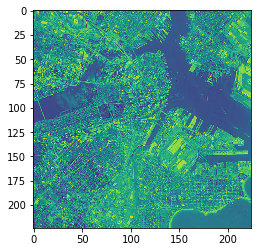

In [27]:
from matplotlib import pyplot as plt
plt.imshow(image_array[image_idx][0], interpolation='nearest')
plt.show()